In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [3]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import traffic collisions data
- about and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::traffic-collisions-asr-t-tbl-001/about

In [4]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')

In [5]:
collision_df = pd.read_csv('../data/raw/Traffic_Collisions.csv')
collision_df.drop(columns=['x','y'], inplace=True)
collision_df

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude
0,GO-20142326328,2014-06-19 12:00:00,June,Thursday,2014,19,NSA,NSA,0,NO,NO,YES,0.000000,0.000000
1,GO-20142327618,2014-06-20 12:00:00,June,Friday,2014,3,NSA,NSA,0,NO,YES,NO,0.000000,0.000000
2,GO-20142329277,2014-06-20 12:00:00,June,Friday,2014,9,NSA,NSA,0,YES,NO,NO,0.000000,0.000000
3,GO-20142329788,2014-06-20 12:00:00,June,Friday,2014,11,NSA,NSA,0,NO,YES,NO,0.000000,0.000000
4,GO-20142329989,2014-06-20 12:00:00,June,Friday,2014,10,NSA,NSA,0,NO,YES,NO,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499533,GO-20198072422,2019-12-08 13:00:00,December,Sunday,2019,9,1,West Humber-Clairville (1),0,NO,NO,YES,-79.621985,43.746878
499534,GO-20198074912,2019-12-20 13:00:00,December,Friday,2019,12,1,West Humber-Clairville (1),0,NO,NO,YES,-79.621985,43.746878
499535,GO-20202240747,2020-11-26 13:00:00,November,Thursday,2020,17,1,West Humber-Clairville (1),0,YES,NO,NO,-79.621985,43.746878
499536,GO-20202312695,2020-12-07 13:00:00,December,Monday,2020,23,1,West Humber-Clairville (1),0,NO,NO,YES,-79.621985,43.746878


In [6]:
collision_df.shape

(499538, 14)

## No missing data

In [7]:
print("Columns with missing data")
collision_df.isna().sum()[collision_df.isna().sum() != 0]

Columns with missing data


Series([], dtype: int64)

## Split hood_id from neighbourhood

In [8]:
collision_df[['neighbourhood', 'hood_id']] = collision_df['neighbourhood'].str.split('(', 1, expand=True)
collision_df['hood_id'] = collision_df['hood_id'].str.split(')', 1, expand=True).iloc[:,0].fillna('NSA')

In [9]:
# check that every NSA in hood_id is NSA in neighbourhood
# should only show "NSA" as the only unique entry
collision_df[collision_df['hood_id'] == "NSA"]['neighbourhood'].unique()

array(['NSA'], dtype=object)

In [10]:
# should only show "NSA" as the only unique entry
collision_df[collision_df['neighbourhood'] == "NSA"]['hood_id'].unique()

array(['NSA'], dtype=object)

In [62]:
mci_select = pd.read_csv('../data/processed/mci_select.csv')

C:\Users\willi\AppData\Local\Temp\ipykernel_28664\163600350.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mci_select = pd.read_csv('../data/processed/mci_select.csv')


In [63]:
# keep the format consistent with major crime indicators
pd.concat([collision_df.iloc[0,:], mci_select.iloc[0,:]], axis=1)

,0,0
occurrence_unique_id,GO-20143403023,GO-20141625305
occurrence_date,2014-12-01 13:00:00,2014-03-02 13:00:00
occurrence_month,December,March
occurrence_dayofweek,Monday,Sunday
occurrence_year,2014,2014
occurrence_hour,10,NaN
hood_id,NSA,1
neighbourhood,NSA,West Humber-Clairville
fatalities,0,NaN
injury_collisions,NO,NaN


In [64]:
collision_df['occurrence_date'] = pd.to_datetime(collision_df['occurrence_date'])

In [65]:
collision_df['occurrence_day'] = collision_df['occurrence_date'].dt.day.astype(int)
collision_df['occurrence_dayofyear'] = collision_df['occurrence_date'].dt.dayofyear.astype(int)

In [66]:
# now columns are similar to mci_select
pd.concat([collision_df.iloc[0,:], mci_select.iloc[0,:]], axis=1)

,0,0
occurrence_unique_id,GO-20143403023,GO-20141625305
occurrence_date,2014-12-01 13:00:00,2014-03-02 13:00:00
occurrence_month,December,March
occurrence_dayofweek,Monday,Sunday
occurrence_year,2014,2014
occurrence_hour,10,NaN
hood_id,NSA,1
neighbourhood,NSA,West Humber-Clairville
fatalities,0,NaN
injury_collisions,NO,NaN


## Checking for inconsistencies

### inconsistency in hour of day

In [67]:
# is the year, month, day etc. consistent with the date column?
print(sum(collision_df.occurrence_date.dt.year != collision_df.occurrence_year))
print(sum(collision_df.occurrence_date.dt.strftime("%B") != collision_df.occurrence_month))
print(sum(collision_df.occurrence_date.dt.day.astype(float) != collision_df.occurrence_day))
print(sum(collision_df.occurrence_date.dt.dayofyear.astype(float) != collision_df.occurrence_dayofyear))
print(sum(collision_df.occurrence_date.dt.strftime("%A") != collision_df.occurrence_dayofweek))
print(sum(collision_df.occurrence_date.dt.hour != collision_df.occurrence_hour))

0
0
0
0
0
466986


In [68]:
# occurencehour looks incorrect
collision_df.loc[collision_df.occurrence_date.dt.hour != collision_df.occurrence_hour, ['occurrence_date', 'occurrence_hour']]

,occurrence_date,occurrence_hour
0,2014-12-01 13:00:00,10
1,2014-12-01 13:00:00,12
2,2014-12-01 13:00:00,14
3,2014-12-01 13:00:00,15
4,2014-11-30 13:00:00,15
...,...,...
499532,2017-01-20 13:00:00,7
499533,2017-02-14 13:00:00,14
499535,2017-02-22 13:00:00,22
499536,2017-04-07 12:00:00,14


In [69]:
# this does not make sense that traffic collisions only occur between 12:00 and 13:00
collision_df.occurrence_date.dt.hour.describe()

count    499538.000000
mean         12.371768
std           0.483277
min          12.000000
25%          12.000000
50%          12.000000
75%          13.000000
max          13.000000
Name: occurrence_date, dtype: float64

In [70]:
# this makes more sense
collision_df.occurrence_hour.describe()

count    499538.000000
mean         13.474358
std           4.921921
min           0.000000
25%          10.000000
50%          14.000000
75%          17.000000
max          23.000000
Name: occurrence_hour, dtype: float64

In [71]:
print("before fixing:", collision_df['occurrence_date'][0])
print("after fixing:", collision_df['occurrence_date'][0].replace(hour=int(collision_df['occurrence_hour'][0])))

before fixing: 2014-12-01 13:00:00
after fixing: 2014-12-01 10:00:00


In [72]:
dates = []
for date, hour in zip(collision_df.occurrence_date, collision_df.occurrence_hour):
    dates.append(date.replace(hour=int(hour)))

In [73]:
collision_df['occurrence_date'] = dates

### inconsistency in hood_ID and neighbourhood

In [74]:
# check if hood_id and neighbourhood are 1-to-1
# number of unique values in hood_id and neighbourhood should be the same
print(len(collision_df.hood_id.unique()), len(collision_df.neighbourhood.unique()))

141 141


In [75]:
check_duplicate = collision_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')

In [76]:
# duplicates in hood_id since some record are of int type, while some are strings
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

,hood_id,neighbourhood,counts


In [77]:
# duplicate neighbourhood values due to white space
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')[:2].values

array([], shape=(0, 3), dtype=object)

In [78]:
collision_df['neighbourhood'] = collision_df['neighbourhood'].str.strip()

In [79]:
# no more duplicates due to white space but not have 2 due to format issues
check_duplicate = collision_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

,hood_id,neighbourhood,counts


In [80]:
# fix duplicate neighbourhood
# collision_df.loc[(collision_df.hood_id == '117') & (collision_df.neighbourhood == 'LAmoreaux'), 'neighbourhood'] = "L'Amoreaux"
# collision_df.loc[(collision_df.hood_id == '118') & (collision_df.neighbourhood == 'Tam OShanter-Sullivan'), 'neighbourhood'] = "Tam O'Shanter-Sullivan"

In [81]:
# no more duplicates
# check_duplicate = collision_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
# check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

In [82]:
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

,hood_id,neighbourhood,counts


### inconsistency vs neighbourhood boundary

In [83]:
merge_df = pd.merge(neighbourhoods[['neighbourhood', 'hood_id']], collision_df[['hood_id', 'neighbourhood']], on=['hood_id'], how='outer', suffixes=('_neighbourhood', '_collision'))
merge_df[merge_df['neighbourhood_neighbourhood'] != merge_df['neighbourhood_collision']].drop_duplicates(subset=['neighbourhood_neighbourhood'])

,neighbourhood_neighbourhood,hood_id,neighbourhood_collision
166733,Tam O'Shanter-Sullivan,118,Tam OShanter-Sullivan
1094828,O'Connor-Parkview,54,OConnor-Parkview
1801709,L'Amoreaux,117,LAmoreaux
2958438,Mimico (includes Humber Bay Shores),17,NaN
2958445,NaN,NSA,NSA


In [84]:
collision_df.loc[(collision_df.hood_id == '118') & (collision_df.neighbourhood == 'Tam OShanter-Sullivan'), 'neighbourhood'] = "Tam O'Shanter-Sullivan"
collision_df.loc[(collision_df.hood_id == '54') & (collision_df.neighbourhood == 'OConnor-Parkview'), 'neighbourhood'] = "O'Connor-Parkview"
collision_df.loc[(collision_df.hood_id == '117') & (collision_df.neighbourhood == 'LAmoreaux'), 'neighbourhood'] = "L'Amoreaux"

In [85]:
# now neighbourhoods are consistent
merge_df = pd.merge(neighbourhoods[['neighbourhood', 'hood_id']], collision_df[['hood_id', 'neighbourhood']], on=['hood_id'])
merge_df[merge_df['neighbourhood_x'] != merge_df['neighbourhood_y']].drop_duplicates(subset=['neighbourhood_x'])

,neighbourhood_x,hood_id,neighbourhood_y


### inconsistentcy in hood_id

In [86]:
sorted(collision_df.hood_id.unique())

['1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '15',
 '16',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '

In [87]:
collision_df[collision_df.hood_id == '17']

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude,occurrence_day,occurrence_dayofyear


In [88]:
collision_df[collision_df.hood_id == 'includes Humber Bay Shores'].head(1)

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude,occurrence_day,occurrence_dayofyear
400014,GO-20148003867,2014-01-27 14:00:00,January,Monday,2014,14,includes Humber Bay Shores,Mimico,0,NO,NO,YES,-79.474,43.630571,27,27


In [89]:
collision_df.loc[collision_df.hood_id == 'includes Humber Bay Shores', 'neighbourhood'] = 'Mimico (includes Humber Bay Shores)'
collision_df.loc[collision_df.hood_id == 'includes Humber Bay Shores', 'hood_id'] = '17'

In [90]:
len(collision_df.hood_id.unique())

141

In [91]:
len(collision_df.neighbourhood.unique())

141

## Fixing data types

In [92]:
collision_df.injury_collisions.unique()

array(['NO', 'YES'], dtype=object)

In [93]:
mapping = {'YES': 1, 'NO': 0}
collision_df.replace({'injury_collisions': mapping,
                      'ftr_collisions': mapping,
                      'pd_collisions': mapping}, inplace=True)

## Impute missing long and lat

In [94]:
collision_df.loc[(collision_df['longitude'] == 0) & (collision_df['latitude'] == 0), ["neighbourhood"]].value_counts()

neighbourhood               
NSA                             69252
Wexford/Maryvale                   64
West Hill                          26
Kennedy Park                       15
Yorkdale-Glen Park                 13
Hillcrest Village                  12
L'Amoreaux                         11
Glenfield-Jane Heights              8
Clairlea-Birchmount                 8
York University Heights             7
Bendale                             7
Highland Creek                      5
Agincourt South-Malvern West        5
Black Creek                         5
Islington-City Centre West          4
Bay Street Corridor                 3
Bayview Woods-Steeles               3
Bathurst Manor                      2
Church-Yonge Corridor               2
Westminster-Branson                 2
West Humber-Clairville              2
Pelmo Park-Humberlea                2
St.Andrew-Windfields                1
Woburn                              1
Bedford Park-Nortown                1
High Park North      

In [95]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
collision_df = collision_df[~((collision_df['longitude'] == 0) & (collision_df['latitude'] == 0) & (collision_df['neighbourhood'] == "NSA"))].reset_index(drop=True)

In [96]:
missing_location = collision_df.loc[(collision_df['longitude'] == 0) & (collision_df['latitude'] == 0)].index
collision_df.loc[missing_location]

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude,occurrence_day,occurrence_dayofyear
0,GO-20143120578,2014-10-17 09:00:00,October,Friday,2014,9,25,Glenfield-Jane Heights,0,0,0,1,0.0,0.0,17,290
1,GO-20141591056,2014-02-24 17:00:00,February,Monday,2014,17,40,St.Andrew-Windfields,0,0,1,0,0.0,0.0,24,55
2,GO-20168056919,2016-12-17 09:00:00,December,Saturday,2016,9,27,York University Heights,0,0,0,1,0.0,0.0,17,352
3,GO-20168059092,2016-12-27 18:00:00,December,Tuesday,2016,18,31,Yorkdale-Glen Park,0,0,1,0,0.0,0.0,27,362
4,GO-20168053844,2016-11-30 18:00:00,November,Wednesday,2016,18,48,Hillcrest Village,0,0,0,1,0.0,0.0,30,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,GO-20198030463,2019-05-20 08:00:00,May,Monday,2019,8,103,Lawrence Park South,0,1,0,0,0.0,0.0,20,140
714,GO-20198076663,2019-12-21 12:00:00,December,Saturday,2019,12,1,West Humber-Clairville,0,0,0,1,0.0,0.0,21,355
715,GO-20201700319,2020-09-08 15:00:00,September,Tuesday,2020,15,45,Parkwoods-Donalda,0,0,1,1,0.0,0.0,8,252
716,GO-20208029200,2020-09-30 15:00:00,September,Wednesday,2020,15,105,Lawrence Park North,0,0,0,1,0.0,0.0,30,274


In [97]:
missing_count = collision_df.loc[missing_location]['hood_id'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'hood_id', 'hood_id':'count'})
missing_count

,hood_id,count
0,119,64
1,136,26
2,124,15
3,31,13
4,48,12
5,117,11
6,25,8
7,120,8
8,127,7
9,27,7


### Generate random points within neighbourhood

In [101]:
# randomly generate points within a defined neighbourhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, hood_id):
    selected_neighbourhood = neighbourhoods.loc[neighbourhoods['hood_id'] == str(hood_id)]
    polygon = selected_neighbourhood['geometry']
    points_x = []
    points_y = []
    count = 0
    try: 
        minx, miny, maxx, maxy = polygon.unique().bounds.flatten().tolist()
    except ValueError:
        print(selected_neighbourhood)
        print(f"No geometry for {hood_id}")
    while len(points_x) < number:
        pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt).values[0]:
            points_x.append(pnt.x)
            points_y.append(pnt.y)
        count += 1
    print(f"{count} points generated but only include the {len(points_x)} points within the neighbourhood")
    return pd.Series([points_x, points_y])

In [102]:
np.random.seed(123)
missing_count[['longitude', 'latitude']] = missing_count.apply(lambda x: generate_random(x['count'],x['hood_id']), axis=1)

86 points generated but only include the 64 points within the neighbourhood
49 points generated but only include the 26 points within the neighbourhood
34 points generated but only include the 15 points within the neighbourhood
15 points generated but only include the 13 points within the neighbourhood
17 points generated but only include the 12 points within the neighbourhood
29 points generated but only include the 11 points within the neighbourhood
10 points generated but only include the 8 points within the neighbourhood
19 points generated but only include the 8 points within the neighbourhood
13 points generated but only include the 7 points within the neighbourhood
11 points generated but only include the 7 points within the neighbourhood
11 points generated but only include the 5 points within the neighbourhood
7 points generated but only include the 5 points within the neighbourhood
8 points generated but only include the 5 points within the neighbourhood
7 points generated bu

In [103]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count['len'] = missing_count['longitude'].apply(lambda x: len(x))
missing_count

,hood_id,count,longitude,latitude,len
0,119,64,"[-79.2905474645034, -79.31024017310659, -79.28...","[43.73845162529402, 43.75118356521948, 43.7450...",64
1,136,26,"[-79.19911824880309, -79.18040350946745, -79.1...","[43.75765197946631, 43.76546946821289, 43.7572...",26
2,124,15,"[-79.26654982146835, -79.27463062049003, -79.2...","[43.72232249578001, 43.7224000798009, 43.71780...",15
3,31,13,"[-79.45996226267624, -79.46065952752981, -79.4...","[43.707040006978474, 43.71897347621641, 43.705...",13
4,48,12,"[-79.3520875268021, -79.33868359752705, -79.36...","[43.80780466875634, 43.80490053510152, 43.8091...",12
5,117,11,"[-79.30228548159286, -79.29101438573844, -79.3...","[43.79210334082548, 43.796763995859656, 43.796...",11
6,25,8,"[-79.51354369472986, -79.51079945917418, -79.5...","[43.74301390592894, 43.756067443593345, 43.739...",8
7,120,8,"[-79.29825934015967, -79.28250707547197, -79.2...","[43.717965362775196, 43.7212468235057, 43.7092...",8
8,127,7,"[-79.25994884109119, -79.25178063892504, -79.2...","[43.76058036572016, 43.75769348547309, 43.7440...",7
9,27,7,"[-79.50047532289943, -79.48947181931631, -79.4...","[43.77822926150175, 43.78110221401124, 43.7503...",7


In [104]:
# impute the missing long and lat values
for i in missing_count["hood_id"].unique():    
    index = (collision_df['hood_id'] == str(i)) & ((collision_df['longitude'] == 0) | (collision_df['latitude'] == 0))
    collision_df.loc[index, ['longitude', 'latitude']] = pd.DataFrame([np.where(collision_df.loc[index, 'longitude'] == 0, 
                                                                      missing_count[missing_count['hood_id'] == str(i)]['longitude'].iloc[0],
                                                                      collision_df.loc[index, 'longitude']),
                                                             np.where(collision_df.loc[index, 'latitude'] == 0, 
                                                                      missing_count[missing_count['hood_id'] == str(i)]['latitude'].iloc[0],
                                                                      collision_df.loc[index, 'latitude'])]).T.values

In [105]:
# check missing long and lat values are now imputed
collision_df.loc[missing_location]

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude,occurrence_day,occurrence_dayofyear
0,GO-20143120578,2014-10-17 09:00:00,October,Friday,2014,9,25,Glenfield-Jane Heights,0,0,0,1,-79.513544,43.743014,17,290
1,GO-20141591056,2014-02-24 17:00:00,February,Monday,2014,17,40,St.Andrew-Windfields,0,0,1,0,-79.350344,43.755212,24,55
2,GO-20168056919,2016-12-17 09:00:00,December,Saturday,2016,9,27,York University Heights,0,0,0,1,-79.500475,43.778229,17,352
3,GO-20168059092,2016-12-27 18:00:00,December,Tuesday,2016,18,31,Yorkdale-Glen Park,0,0,1,0,-79.459962,43.707040,27,362
4,GO-20168053844,2016-11-30 18:00:00,November,Wednesday,2016,18,48,Hillcrest Village,0,0,0,1,-79.352088,43.807805,30,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,GO-20198030463,2019-05-20 08:00:00,May,Monday,2019,8,103,Lawrence Park South,0,1,0,0,-79.413877,43.711377,20,140
714,GO-20198076663,2019-12-21 12:00:00,December,Saturday,2019,12,1,West Humber-Clairville,0,0,0,1,-79.619428,43.721281,21,355
715,GO-20201700319,2020-09-08 15:00:00,September,Tuesday,2020,15,45,Parkwoods-Donalda,0,0,1,1,-79.333731,43.759628,8,252
716,GO-20208029200,2020-09-30 15:00:00,September,Wednesday,2020,15,105,Lawrence Park North,0,0,0,1,-79.410315,43.725513,30,274


### Add geometry points

In [106]:
collision_df['geometry'] = collision_df.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [107]:
collision_point = gpd.GeoDataFrame(collision_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

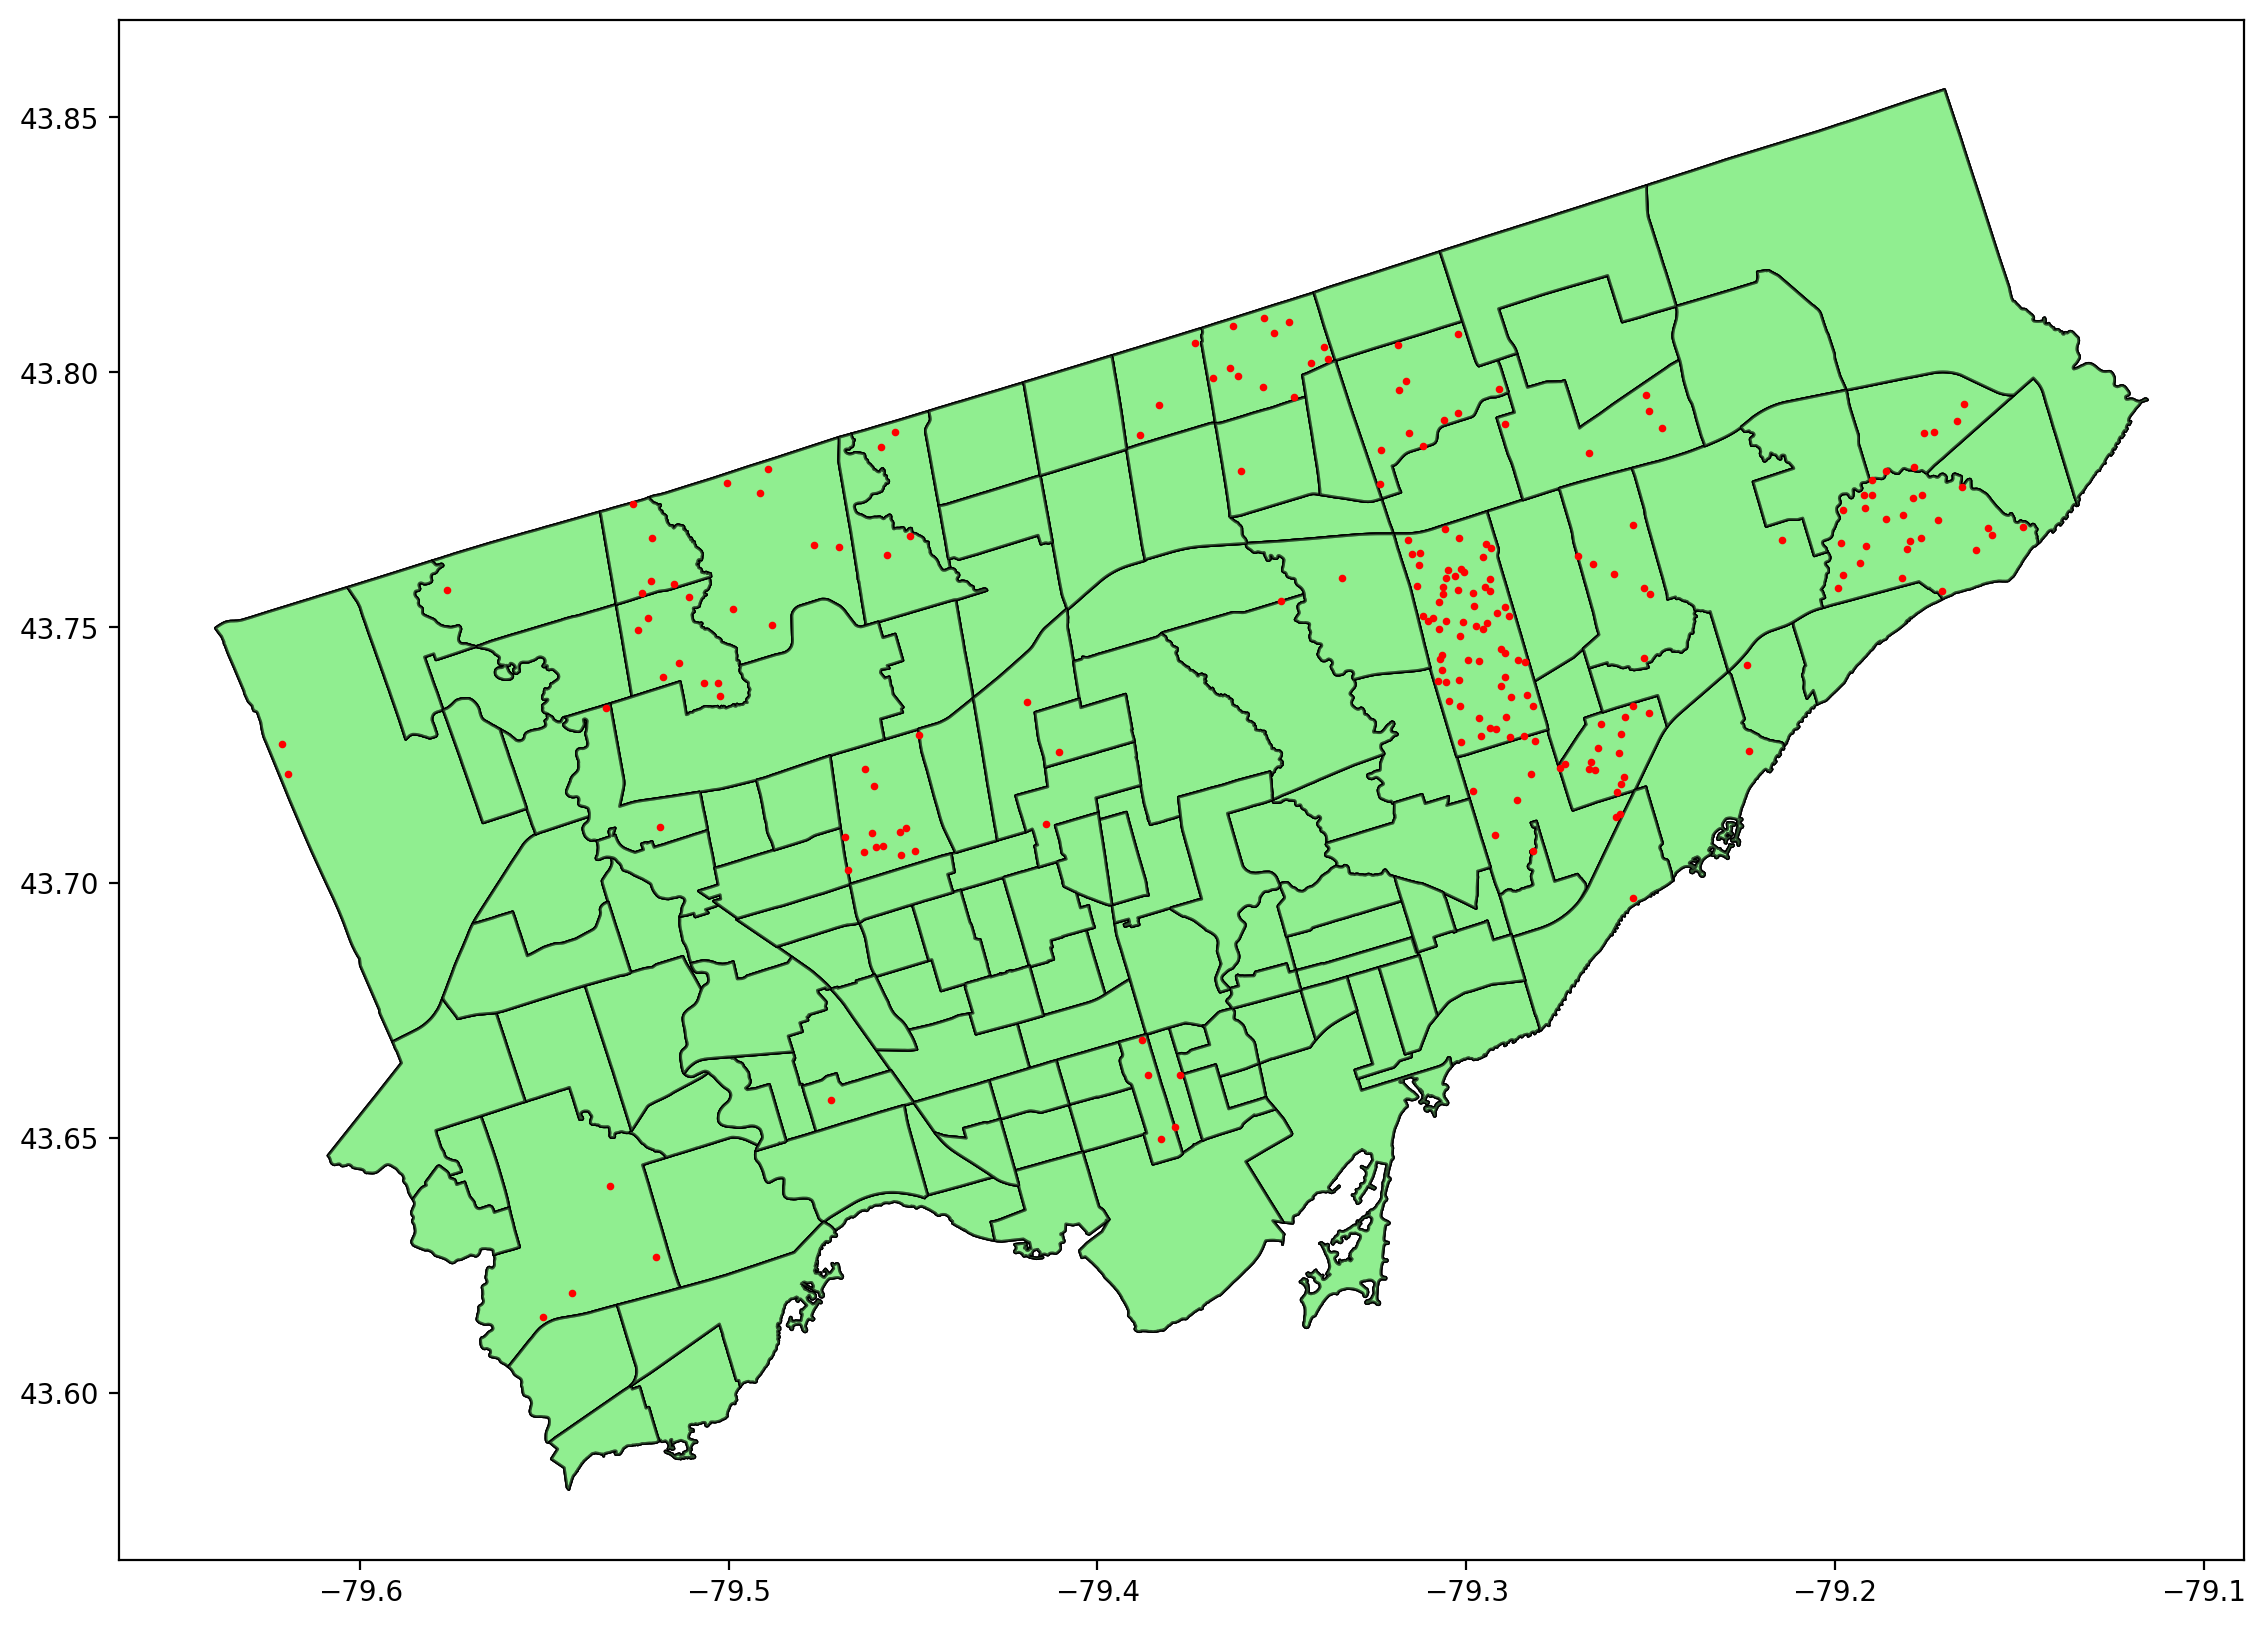

In [108]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

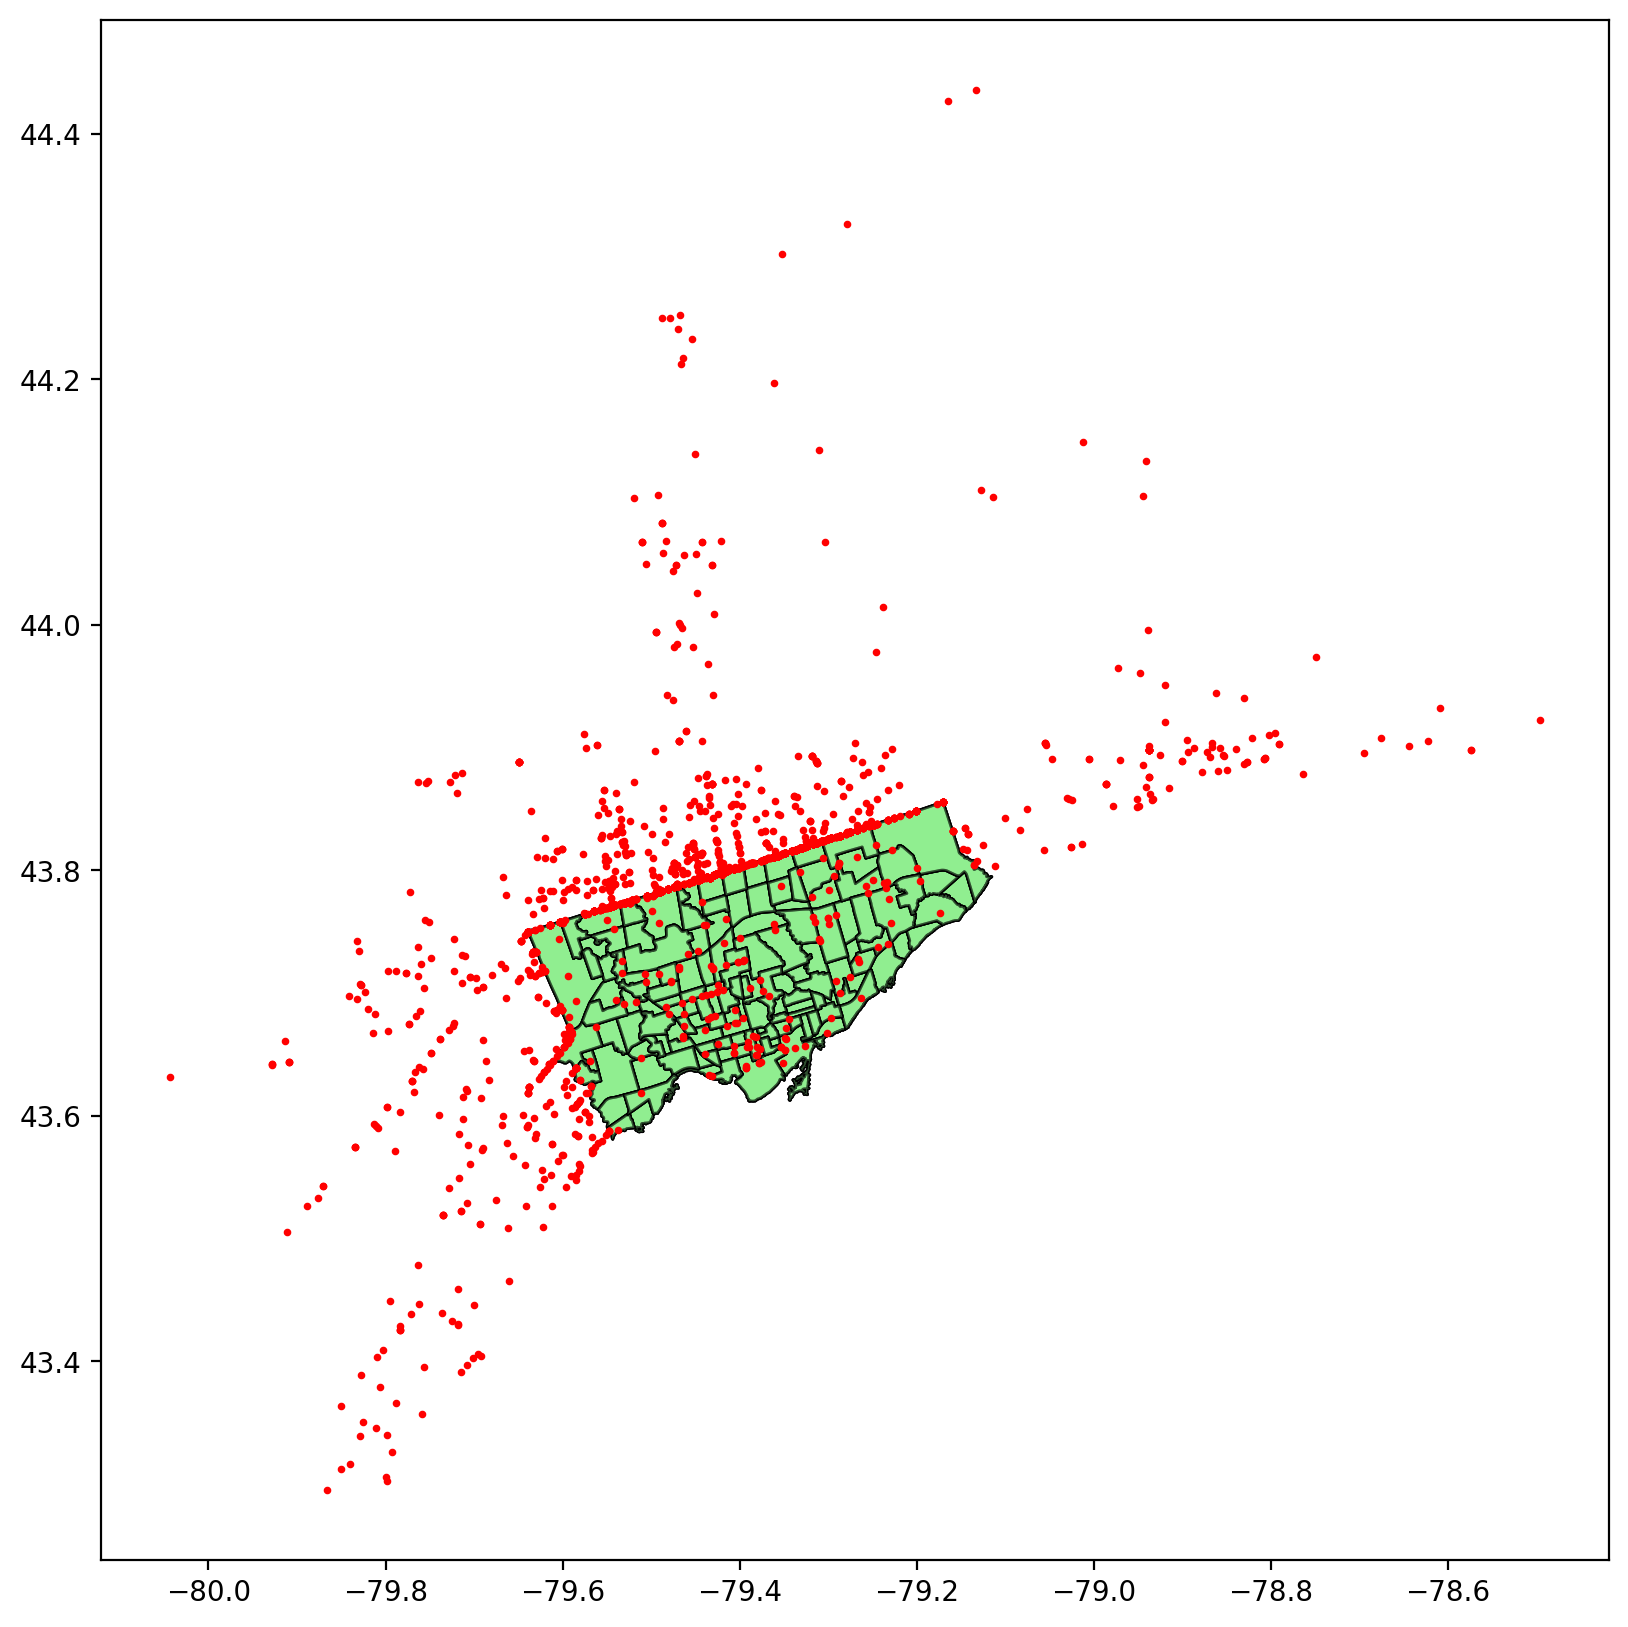

In [109]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [110]:
# get the points contained within the neighbourhood
NSA_within_neighbourhood = gpd.sjoin(collision_point[collision_point['neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
collision_point.loc[NSA_within_neighbourhood.index, ['hood_id', 'neighbourhood']] = NSA_within_neighbourhood[['hood_id_right', 'neighbourhood_right']].values

c:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

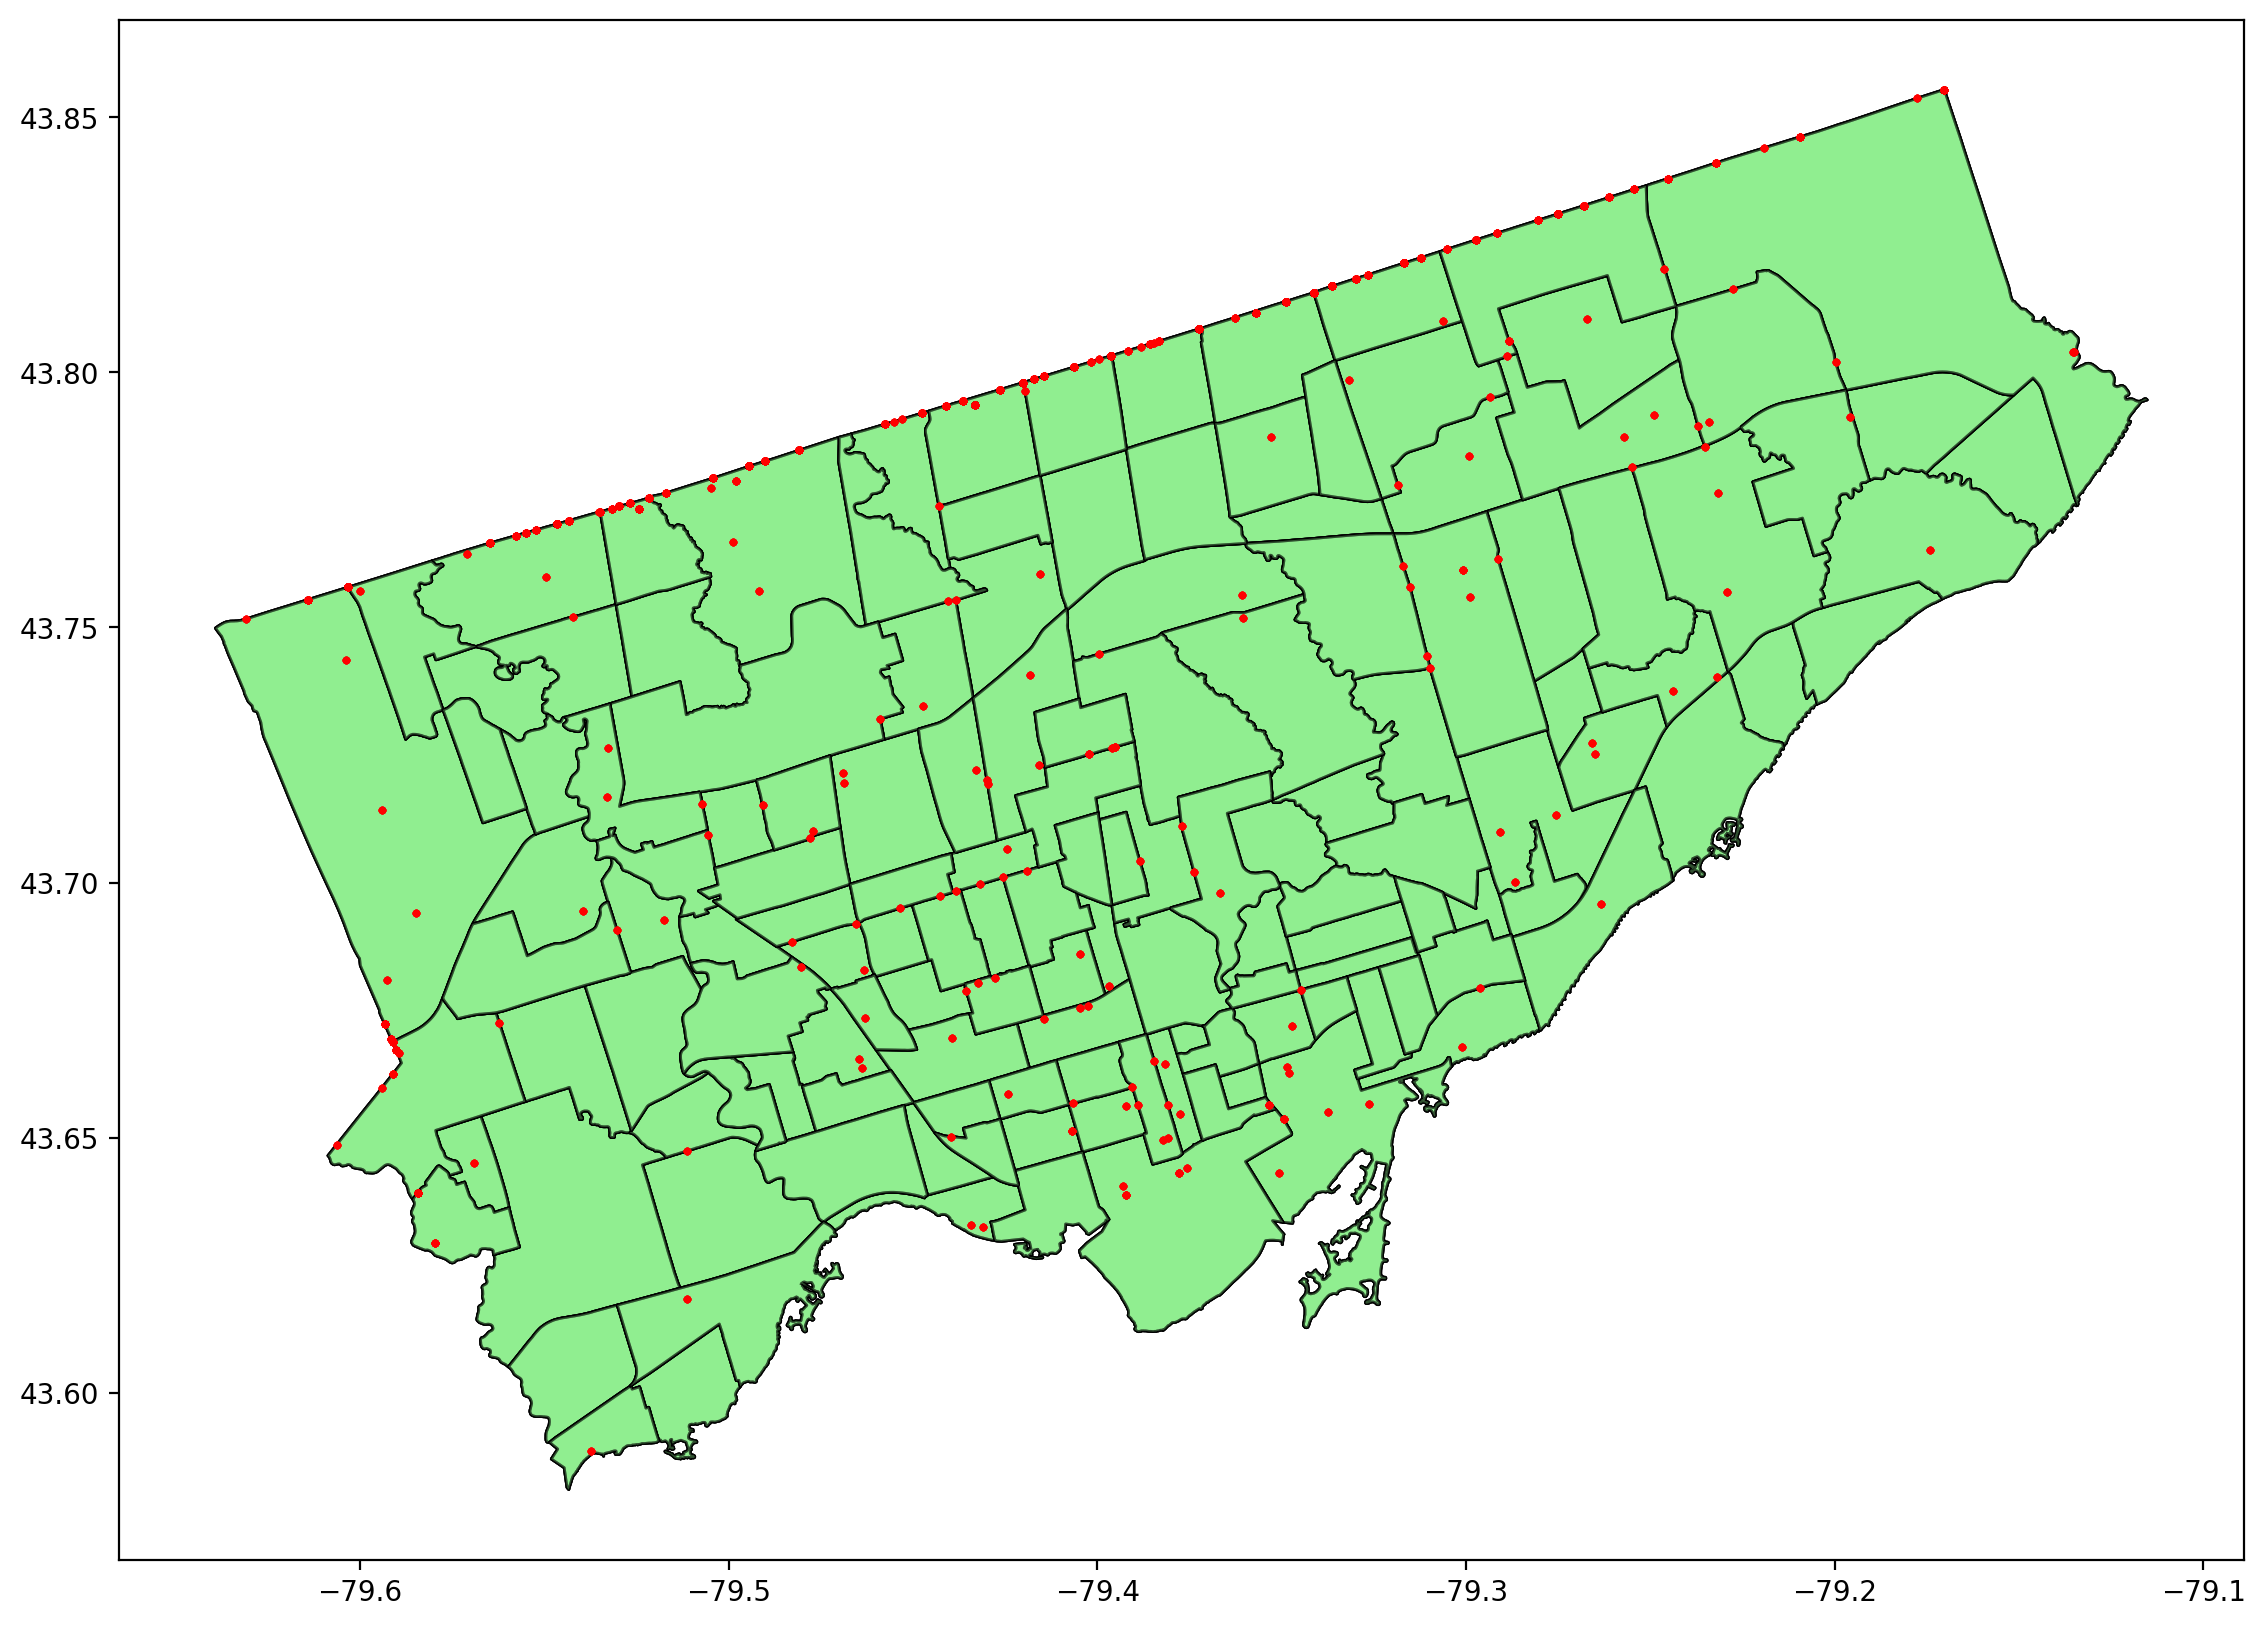

In [111]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

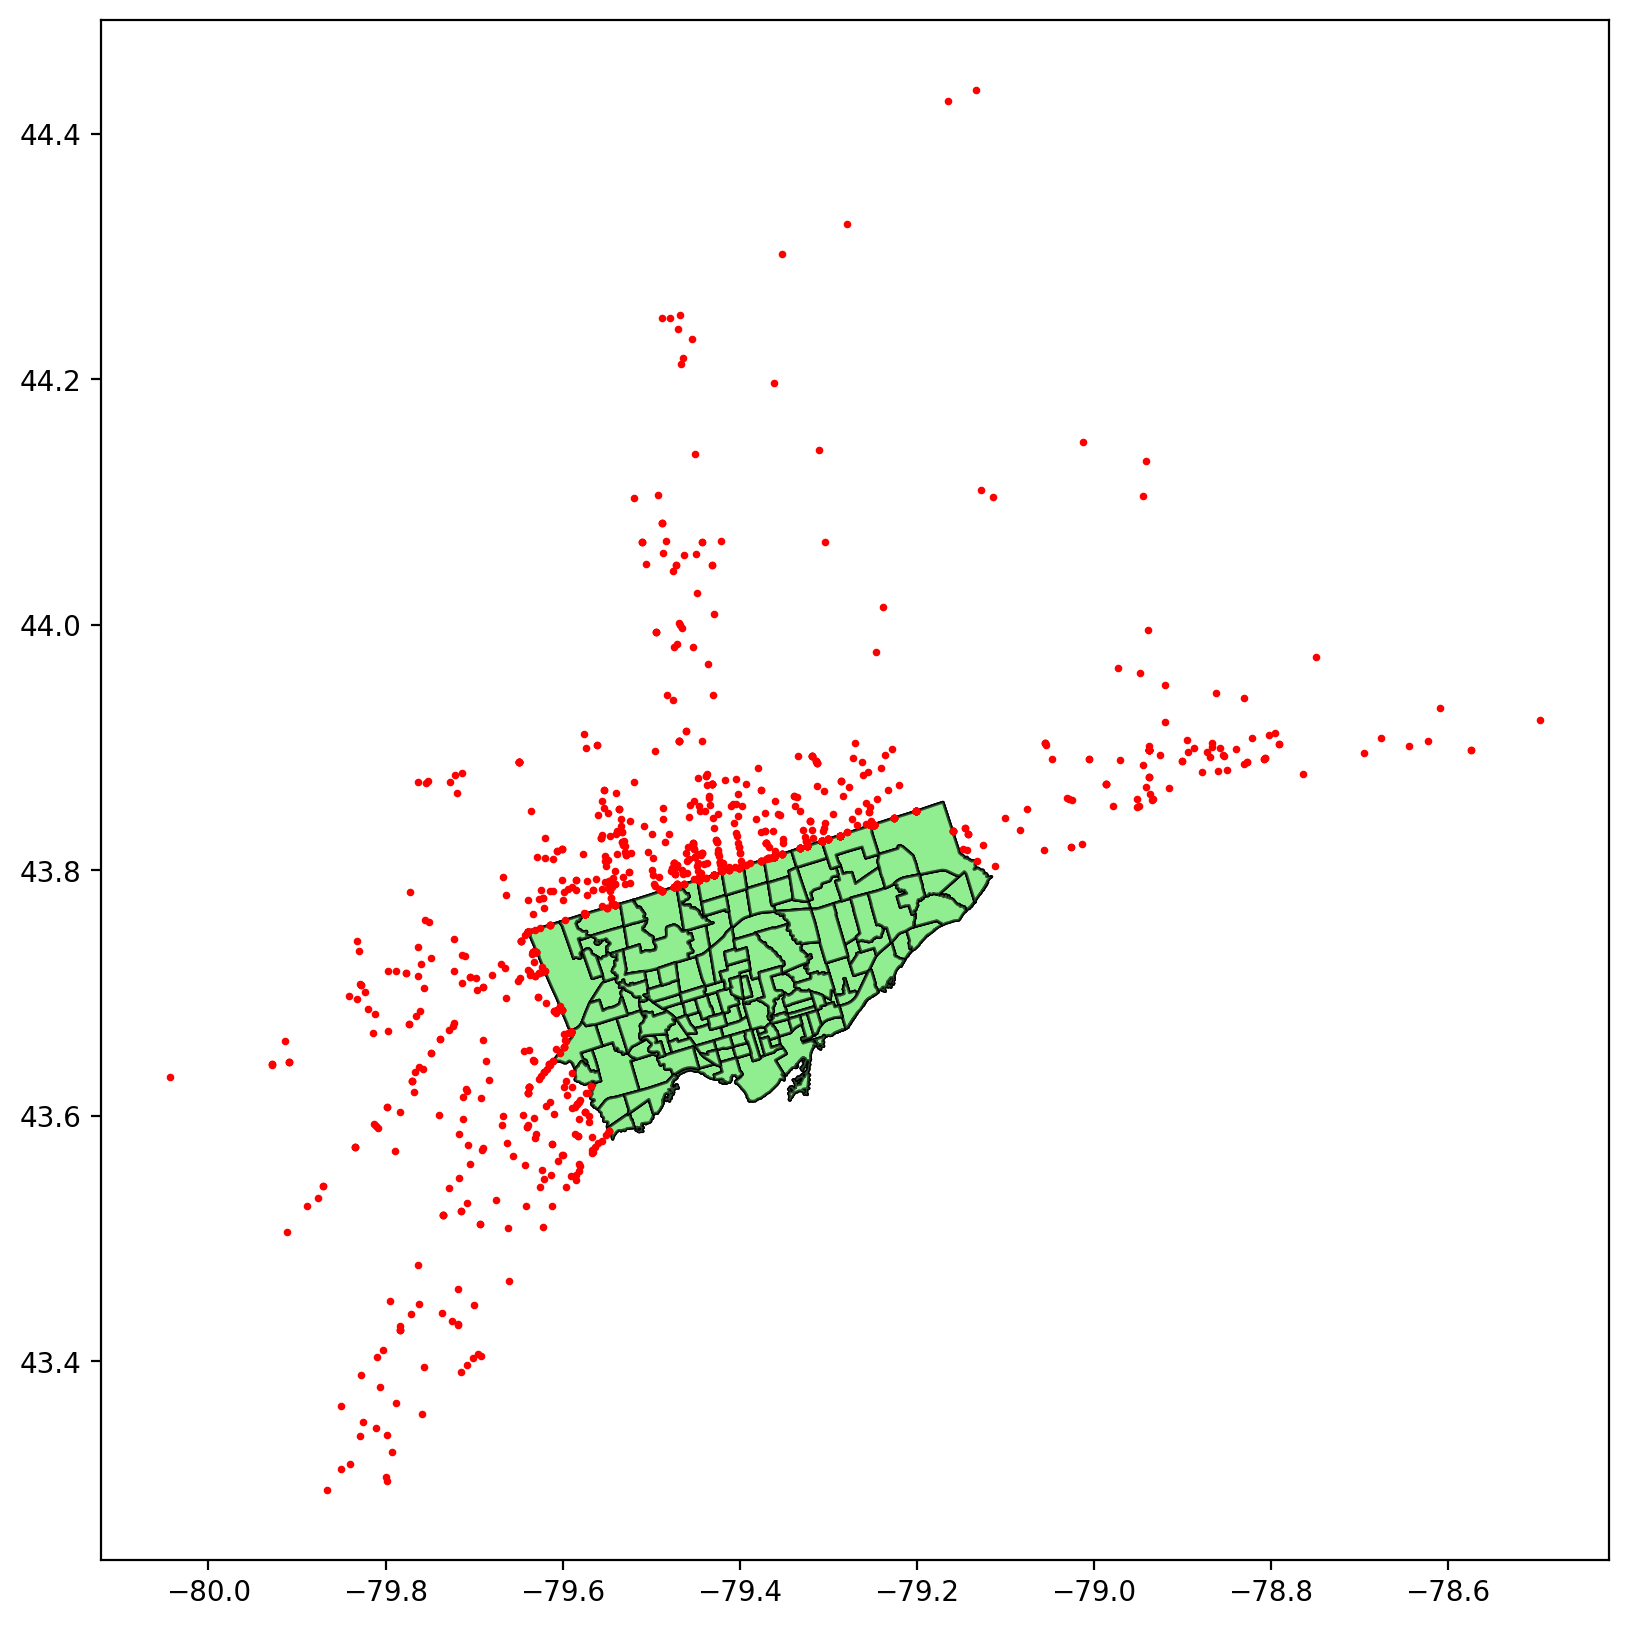

In [112]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

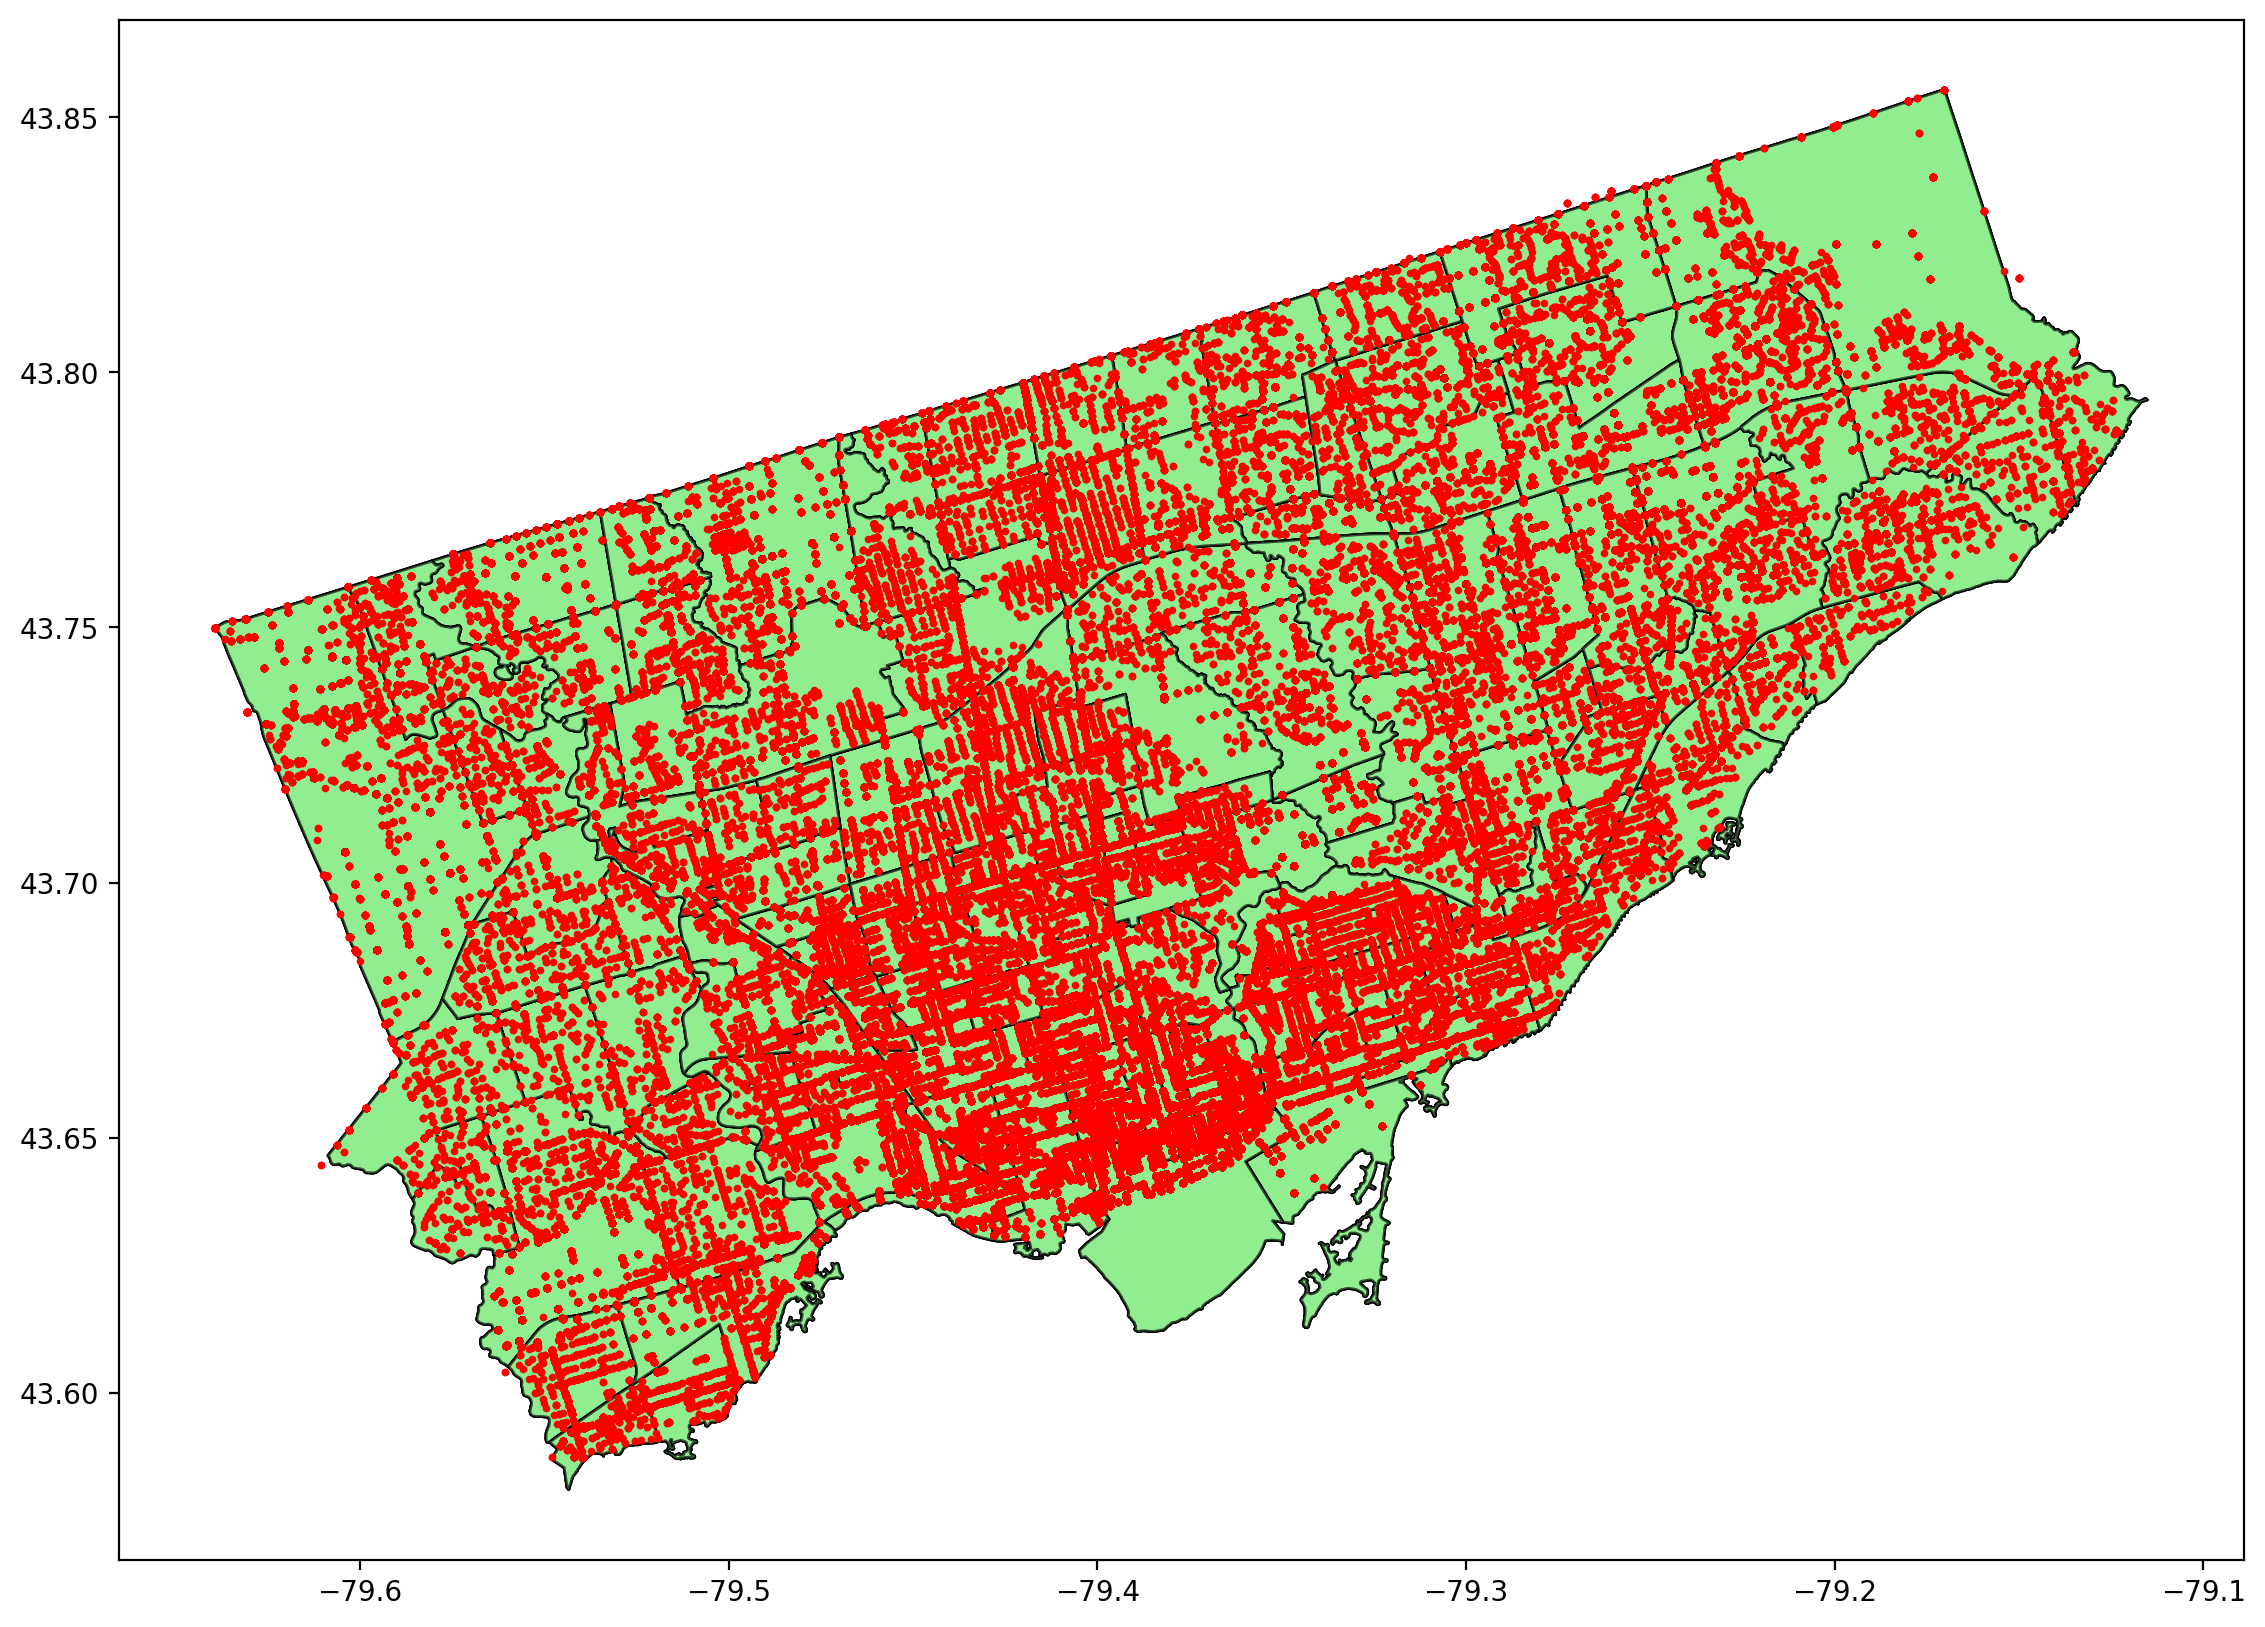

In [113]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

# Add Fatal_Collisions

In [114]:
collision_point['fatal_collisions'] = [1 if x != 0 else 0 for x in collision_point['fatalities']]

# Output

In [115]:
collision_point

,occurrence_unique_id,occurrence_date,occurrence_month,occurrence_dayofweek,occurrence_year,occurrence_hour,hood_id,neighbourhood,fatalities,injury_collisions,ftr_collisions,pd_collisions,longitude,latitude,occurrence_day,occurrence_dayofyear,geometry,fatal_collisions
0,GO-20143120578,2014-10-17 09:00:00,October,Friday,2014,9,25,Glenfield-Jane Heights,0,0,0,1,-79.513544,43.743014,17,290,POINT (-79.51354 43.74301),0
1,GO-20141591056,2014-02-24 17:00:00,February,Monday,2014,17,40,St.Andrew-Windfields,0,0,1,0,-79.350344,43.755212,24,55,POINT (-79.35034 43.75521),0
2,GO-20168056919,2016-12-17 09:00:00,December,Saturday,2016,9,27,York University Heights,0,0,0,1,-79.500475,43.778229,17,352,POINT (-79.50048 43.77823),0
3,GO-20168059092,2016-12-27 18:00:00,December,Tuesday,2016,18,31,Yorkdale-Glen Park,0,0,1,0,-79.459962,43.707040,27,362,POINT (-79.45996 43.70704),0
4,GO-20168053844,2016-11-30 18:00:00,November,Wednesday,2016,18,48,Hillcrest Village,0,0,0,1,-79.352088,43.807805,30,335,POINT (-79.35209 43.80780),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430281,GO-20178006796,2017-02-14 14:00:00,February,Tuesday,2017,14,NSA,NSA,0,0,0,1,-79.639225,43.749873,14,45,POINT (-79.63923 43.74987),0
430282,GO-20178007507,2017-02-18 13:00:00,February,Saturday,2017,13,NSA,NSA,0,0,1,0,-79.639225,43.749873,18,49,POINT (-79.63923 43.74987),0
430283,GO-20178008123,2017-02-22 22:00:00,February,Wednesday,2017,22,1,West Humber-Clairville,0,0,0,1,-79.639225,43.749873,22,53,POINT (-79.63923 43.74987),0
430284,GO-20178014940,2017-04-07 14:00:00,April,Friday,2017,14,NSA,NSA,0,0,0,1,-79.639225,43.749873,7,97,POINT (-79.63923 43.74987),0


In [135]:
collision_point['occurrence_quarter'] = collision_point.occurrence_date.dt.quarter

In [136]:
# output file to clean_data folder
# csv instead of geojson due to size
collision_point.drop(columns=['geometry']).to_csv('../data/processed/collision_select.csv', index=False)

# Aggregate traffic collsions by neighbourhood

<AxesSubplot:xlabel='occurrence_year'>

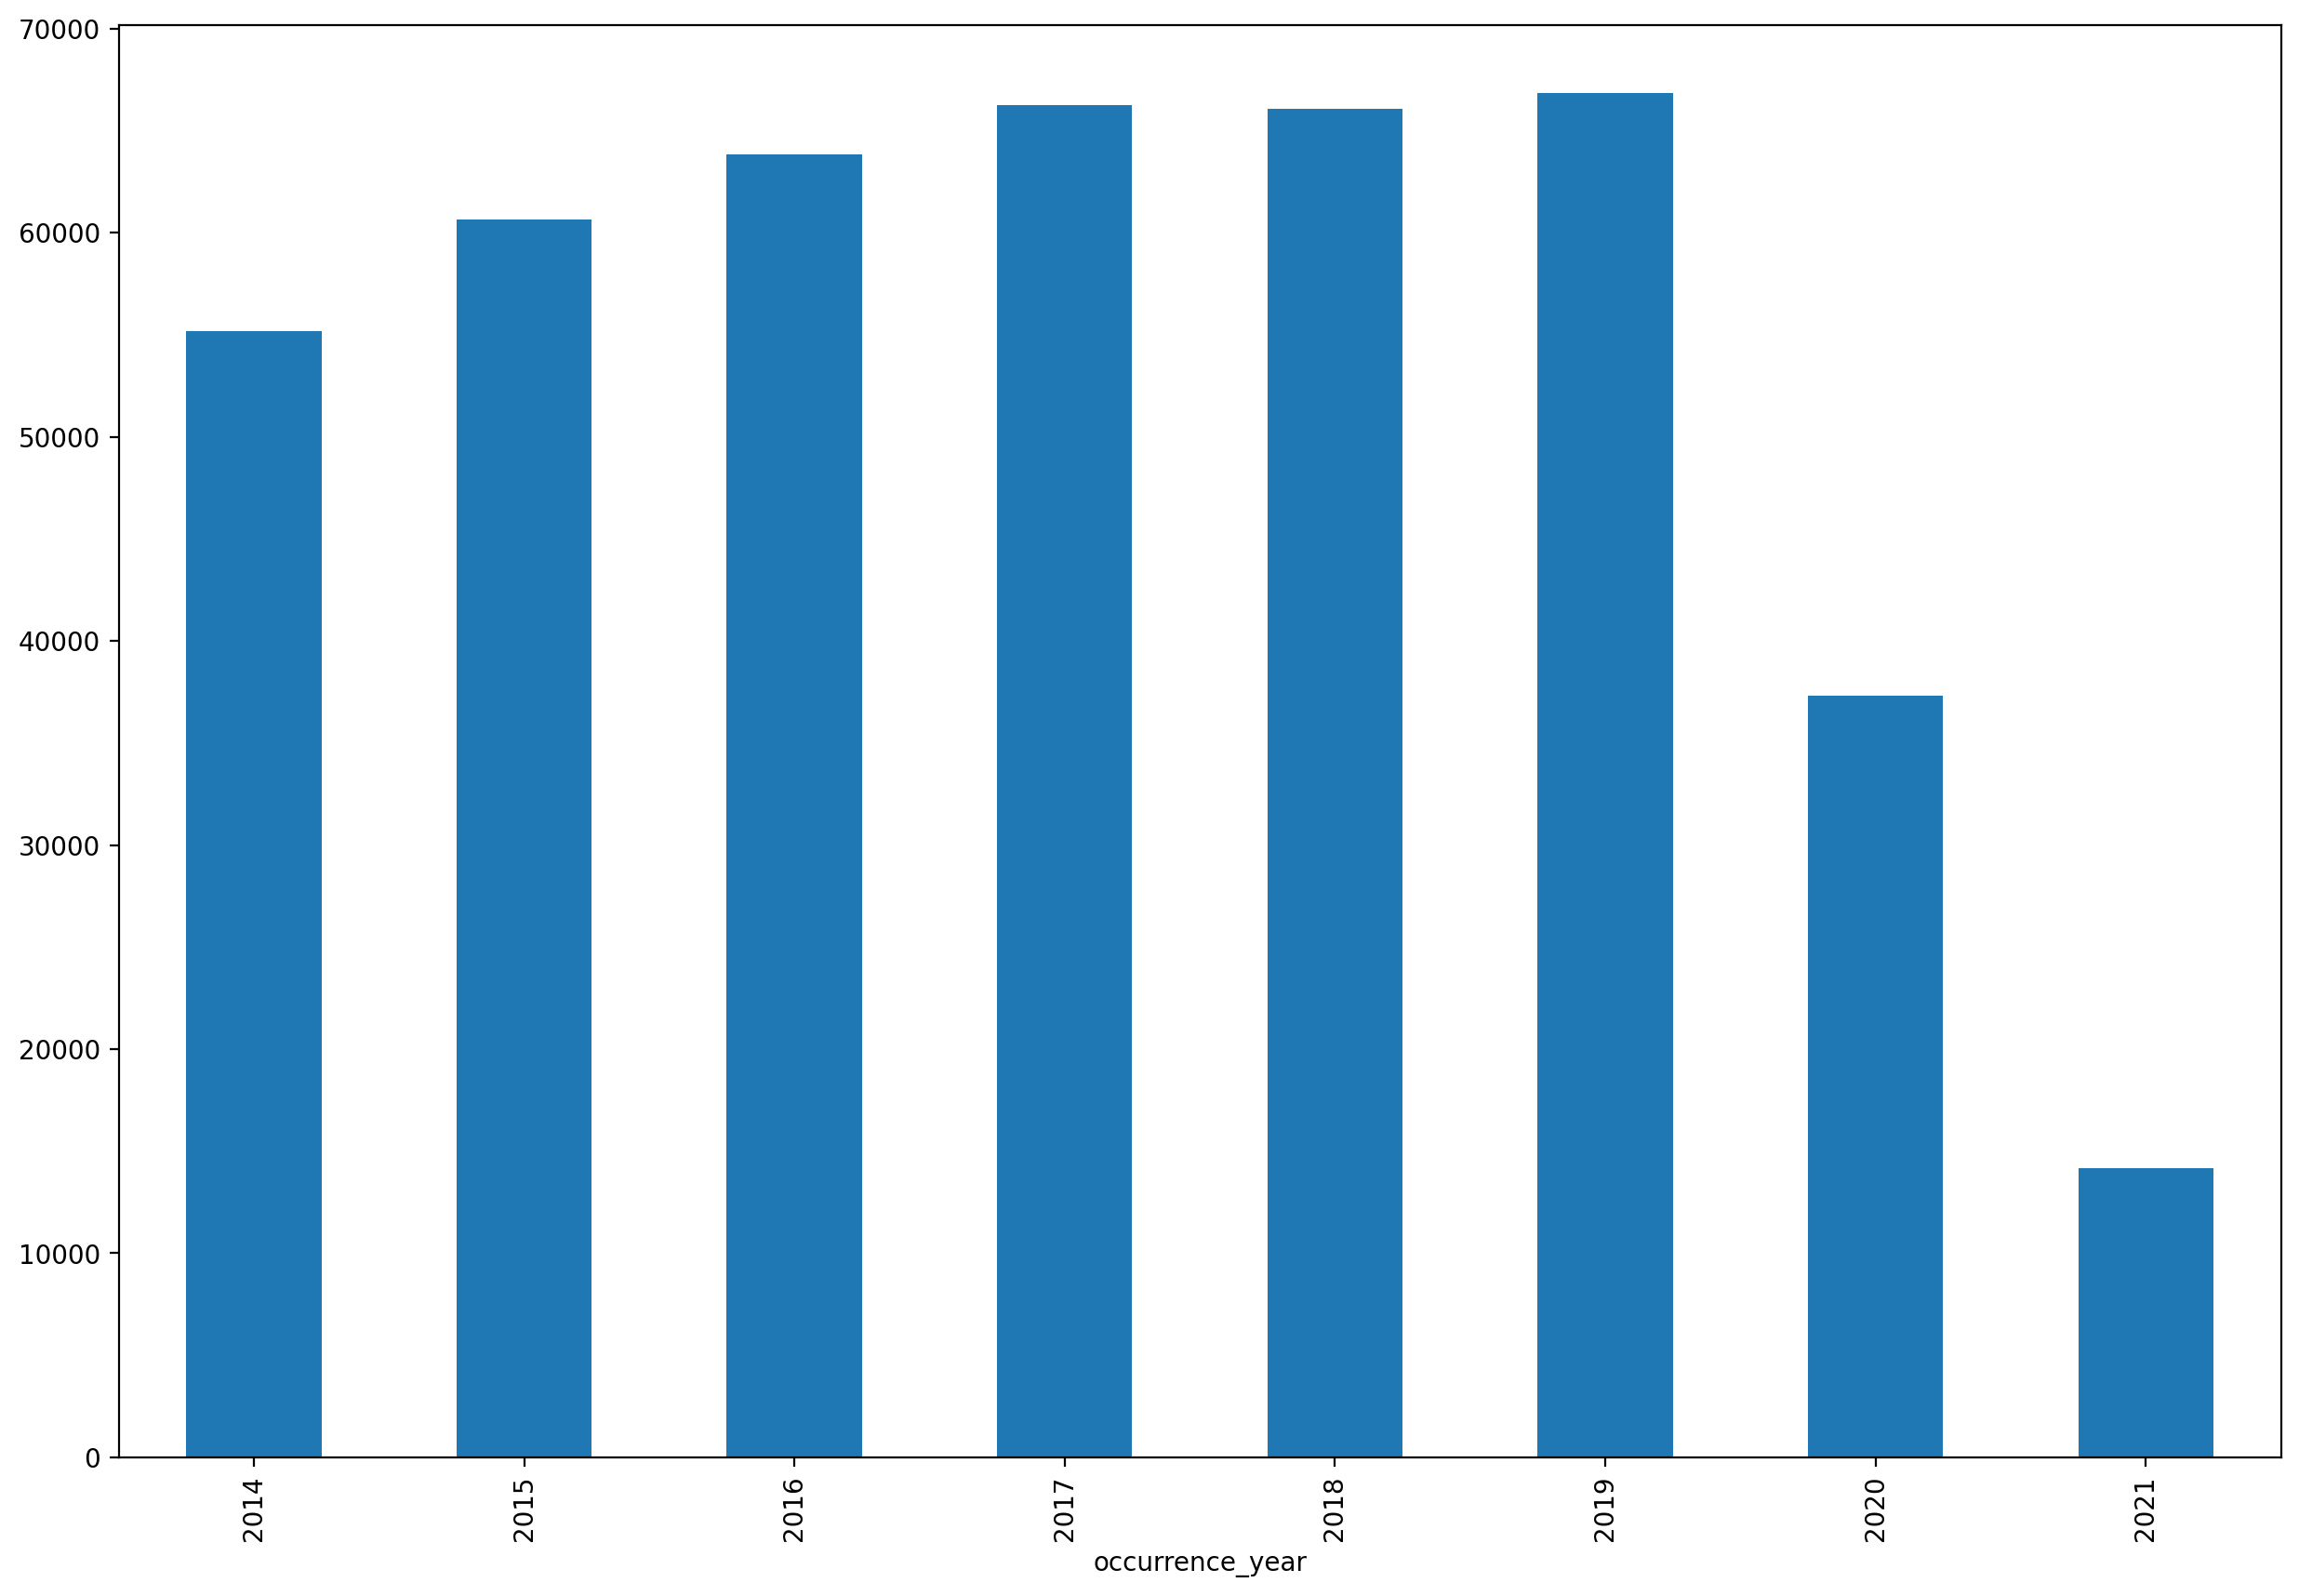

In [117]:
# There is limited data for crimes which happened before 2014
collision_point.groupby("occurrence_year").size().plot(kind="bar")

In [151]:
# filter out data before 2014 and marked as NSA (outside City of Toronto)
collision_groupby = collision_point[collision_point.neighbourhood != "NSA"].\
    groupby(["neighbourhood", "hood_id", "occurrence_year", "occurrence_quarter"]).\
    agg({
        "occurrence_unique_id": "size",
        "fatal_collisions": "sum",
        "injury_collisions": "sum",
        "ftr_collisions": "sum",
        "pd_collisions": "sum"})
    
# unstack to fill those combinations with no record with 0
collision_groupby = collision_groupby.unstack(fill_value=0).stack().reset_index()

collision_groupby.rename(columns={"occurrence_unique_id": "collision"}, inplace=True)
collision_groupby = collision_groupby.melt(id_vars=["neighbourhood", "hood_id", "occurrence_year", "occurrence_quarter"],
                                           var_name="collision_type",
                                           value_name="count")
collision_groupby

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,collision_type,count
0,Agincourt North,129,2014,1,collision,145
1,Agincourt North,129,2014,2,collision,102
2,Agincourt North,129,2014,3,collision,114
3,Agincourt North,129,2014,4,collision,122
4,Agincourt North,129,2015,1,collision,155
...,...,...,...,...,...,...
22395,Yorkdale-Glen Park,31,2020,4,pd_collisions,84
22396,Yorkdale-Glen Park,31,2021,1,pd_collisions,60
22397,Yorkdale-Glen Park,31,2021,2,pd_collisions,75
22398,Yorkdale-Glen Park,31,2021,3,pd_collisions,0


In [152]:
collision_groupby.occurrence_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

## Add neighbourhood information

In [139]:
neighbourhoods_select = neighbourhoods[['hood_id', 'occurrence_year', 'area', 'population']]
neighbourhoods_select

,hood_id,occurrence_year,area,population
0,97,2014,1.161318,12597
1,97,2015,1.161318,12746
2,97,2016,1.161318,12950
3,97,2017,1.161318,13214
4,97,2018,1.161318,13508
...,...,...,...,...
975,17,2016,7.059185,35223
976,17,2017,7.059185,36043
977,17,2018,7.059185,31671
978,17,2019,7.059185,37839


In [140]:
neighbourhoods.occurrence_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [141]:
neighbourhood_2021 = neighbourhoods_select[neighbourhoods_select['occurrence_year'] == 2020].copy(deep = True)
neighbourhood_2021['occurrence_year'] = 2021
# extrapolate population in 2021 based on population growth rate from 2019 to 2020
neighbourhood_2021['population'] = neighbourhoods_select.loc[neighbourhoods_select['occurrence_year'] == 2020, 'population'].values / neighbourhoods_select.loc[neighbourhoods_select['occurrence_year'] == 2019, 'population'].values * neighbourhoods_select.loc[neighbourhoods_select['occurrence_year'] == 2020, 'population'].values
neighbourhood_2021

,hood_id,occurrence_year,area,population
6,97,2021,1.161318,14381.225905
13,27,2021,13.246740,30713.194927
20,38,2021,5.346147,18515.368646
27,31,2021,6.038389,18170.512669
34,16,2021,7.946474,27818.013812
...,...,...,...,...
951,46,2021,2.967498,16985.994859
958,94,2021,1.682177,16351.031153
965,56,2021,4.784690,18969.209689
972,108,2021,1.830376,15620.936759


In [142]:
neighbourhoods_final = pd.concat([neighbourhoods_select, neighbourhood_2021], axis = 0).sort_values(by = ['hood_id', 'occurrence_year'])
neighbourhoods_final

,hood_id,occurrence_year,area,population
287,1,2014,30.145225,34745.000000
288,1,2015,30.145225,34557.000000
289,1,2016,30.145225,34418.000000
290,1,2017,30.145225,35085.000000
291,1,2018,30.145225,35773.000000
...,...,...,...,...
703,99,2017,3.088902,17448.000000
704,99,2018,3.088902,17633.000000
705,99,2019,3.088902,17812.000000
706,99,2020,3.088902,17972.000000


In [153]:
collision_groupby

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,collision_type,count
0,Agincourt North,129,2014,1,collision,145
1,Agincourt North,129,2014,2,collision,102
2,Agincourt North,129,2014,3,collision,114
3,Agincourt North,129,2014,4,collision,122
4,Agincourt North,129,2015,1,collision,155
...,...,...,...,...,...,...
22395,Yorkdale-Glen Park,31,2020,4,pd_collisions,84
22396,Yorkdale-Glen Park,31,2021,1,pd_collisions,60
22397,Yorkdale-Glen Park,31,2021,2,pd_collisions,75
22398,Yorkdale-Glen Park,31,2021,3,pd_collisions,0


In [154]:
collision_merge = neighbourhoods_final.merge(collision_groupby, how='outer', on=['hood_id', 'occurrence_year'])
collision_merge

,hood_id,occurrence_year,area,population,neighbourhood,occurrence_quarter,collision_type,count
0,1,2014,30.145225,34745.000000,West Humber-Clairville,1,collision,352
1,1,2014,30.145225,34745.000000,West Humber-Clairville,2,collision,300
2,1,2014,30.145225,34745.000000,West Humber-Clairville,3,collision,317
3,1,2014,30.145225,34745.000000,West Humber-Clairville,4,collision,312
4,1,2014,30.145225,34745.000000,West Humber-Clairville,1,fatal_collisions,0
...,...,...,...,...,...,...,...,...
22395,99,2021,3.088902,18133.437233,Mount Pleasant East,4,ftr_collisions,0
22396,99,2021,3.088902,18133.437233,Mount Pleasant East,1,pd_collisions,47
22397,99,2021,3.088902,18133.437233,Mount Pleasant East,2,pd_collisions,36
22398,99,2021,3.088902,18133.437233,Mount Pleasant East,3,pd_collisions,0


In [155]:
collision_merge.isna().sum()

hood_id               0
occurrence_year       0
area                  0
population            0
neighbourhood         0
occurrence_quarter    0
collision_type        0
count                 0
dtype: int64

## add rate / density

In [156]:
# rate: number of collisions per 100k people
collision_merge['rate'] = collision_merge['count'] / collision_merge['population'] * 10**5
# density: number of collisions per 1km^2
collision_merge['density'] = collision_merge['count'] / collision_merge['area']

In [158]:
collision_merge

,hood_id,occurrence_year,area,population,neighbourhood,occurrence_quarter,collision_type,count,rate,density
0,1,2014,30.145225,34745.000000,West Humber-Clairville,1,collision,352,1013.095409,11.676808
1,1,2014,30.145225,34745.000000,West Humber-Clairville,2,collision,300,863.433588,9.951825
2,1,2014,30.145225,34745.000000,West Humber-Clairville,3,collision,317,912.361491,10.515761
3,1,2014,30.145225,34745.000000,West Humber-Clairville,4,collision,312,897.970931,10.349898
4,1,2014,30.145225,34745.000000,West Humber-Clairville,1,fatal_collisions,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
22395,99,2021,3.088902,18133.437233,Mount Pleasant East,4,ftr_collisions,0,0.000000,0.000000
22396,99,2021,3.088902,18133.437233,Mount Pleasant East,1,pd_collisions,47,259.189691,15.215760
22397,99,2021,3.088902,18133.437233,Mount Pleasant East,2,pd_collisions,36,198.528274,11.654625
22398,99,2021,3.088902,18133.437233,Mount Pleasant East,3,pd_collisions,0,0.000000,0.000000


In [159]:
collision_melt = collision_merge.melt(id_vars=['neighbourhood', 'hood_id', 'occurrence_year', 'occurrence_quarter', 'area', 'population', 'collision_type'],
                                      value_vars=['count', 'rate', 'density'],
                                      var_name='type',
                                      value_name='value')
collision_melt

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,area,population,collision_type,type,value
0,West Humber-Clairville,1,2014,1,30.145225,34745.000000,collision,count,352.000000
1,West Humber-Clairville,1,2014,2,30.145225,34745.000000,collision,count,300.000000
2,West Humber-Clairville,1,2014,3,30.145225,34745.000000,collision,count,317.000000
3,West Humber-Clairville,1,2014,4,30.145225,34745.000000,collision,count,312.000000
4,West Humber-Clairville,1,2014,1,30.145225,34745.000000,fatal_collisions,count,0.000000
...,...,...,...,...,...,...,...,...,...
67195,Mount Pleasant East,99,2021,4,3.088902,18133.437233,ftr_collisions,density,0.000000
67196,Mount Pleasant East,99,2021,1,3.088902,18133.437233,pd_collisions,density,15.215760
67197,Mount Pleasant East,99,2021,2,3.088902,18133.437233,pd_collisions,density,11.654625
67198,Mount Pleasant East,99,2021,3,3.088902,18133.437233,pd_collisions,density,0.000000


In [161]:
collision_melt.to_csv('../data/processed/neighbourhoods_collision.csv', index=False)